In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb
import re
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Inline plotting
%matplotlib inline
# Pandas options
pd.set_option('max_colwidth', 2000)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read the data to pandas dataframes
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
# Describe the training data
df.describe().target.apply(lambda x: '{:.0f}'.format(x))

count    1306122
mean           0
std            0
min            0
25%            0
50%            0
75%            0
max            1
Name: target, dtype: object

In [5]:
# Describe the test data
df_test['qid'].describe()

count                    56370
unique                   56370
top       76ed34c74ed161cb0fd4
freq                         1
Name: qid, dtype: object

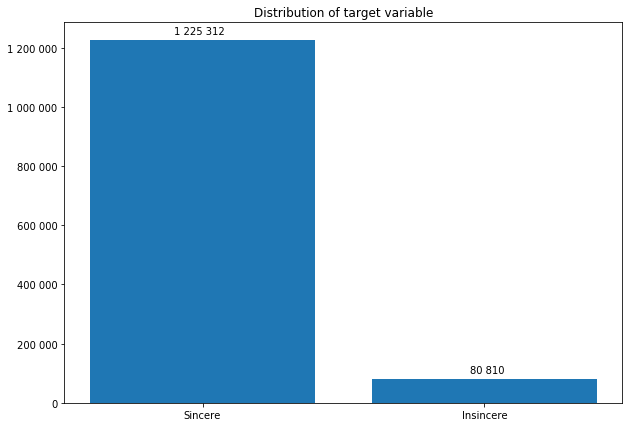

In [6]:
# Plot number of records per target variable

# Create barchart based on target value counts
fig, ax = plt.subplots(figsize=(10,7))
target_dist = df.target.value_counts()
plt.bar(target_dist.index.astype('str'), target_dist.values)

#Format x and y labels
vals = ax.get_yticks()
ax.set_yticklabels([format(label, ',.0f').replace(',', ' ') for label in vals])
ax.set_xticklabels(['Sincere' if label==0 else 'Insincere' for label in vals])

# Format text for plotting on bars
pos_text = ('{:,.0f}'.format(target_dist.iloc[0]).replace(',', ' '),
            '{:,.0f}'.format(target_dist.iloc[1]).replace(',', ' '))

# Add values on bars
plt.text(x=0-0.1, y = target_dist.iloc[0] + 20000, s=pos_text[0])
plt.text(x=1-0.05, y = target_dist.iloc[1] + 20000, s=pos_text[1])
plt.title('Distribution of target variable', fontsize=12)
plt.show()

In [7]:
# Print imbalance number for inclusion in report
print(target_dist[0] / target_dist.sum() * 100)
print(target_dist[1] / target_dist.sum() * 100)

93.81298224821265
6.187017751787352


In [8]:
# Add derived word count and text length to dataframes
df['raw_word_count'] = df.question_text.apply(lambda x: len(x.split()))
df['raw_question_text_length'] = df.question_text.apply(len)

df_test['raw_word_count'] = df.question_text.apply(lambda x: len(x.split()))
df_test['raw_question_text_length'] = df.question_text.apply(len)

In [10]:
# Just double checking that the number of records should be equal when  aggregating word-counts
print(df.raw_word_count.value_counts().sum())
print(df.shape[0])

1306122
1306122


In [11]:
# Get statistics on new fields
df.describe().transpose().iloc[[1,2],[0,1,3,7]]

,count,mean,min,max
raw_word_count,1306122.0000000000,12.8036094637,1.0000000000,134.0000000000
raw_question_text_length,1306122.0000000000,70.6788355146,1.0000000000,1017.0000000000


In [12]:
# Get statistics on new fields test
df_test.describe().transpose().iloc[:,[0,1,3,7]]

,count,mean,min,max
raw_word_count,56370.0000000000,12.7586304772,2.0000000000,65.0000000000
raw_question_text_length,56370.0000000000,70.4332623736,11.0000000000,294.0000000000


In [14]:
# View median word count and text length
df[['raw_word_count', 'raw_question_text_length']].median()

raw_word_count             11.0000000000
raw_question_text_length   60.0000000000
dtype: float64

In [15]:
# View median word count and text length test
df_test[['raw_word_count', 'raw_question_text_length']].median()

raw_word_count             11.0000000000
raw_question_text_length   60.0000000000
dtype: float64

In [17]:
# Test cummulative share of total
(df.raw_word_count.value_counts().sort_index().agg('cumsum') / df.shape[0]).head(20)

1    0.0000183750
2    0.0000658438
3    0.0048295642
4    0.0218478825
5    0.0554825659
6    0.1135651953
7    0.1938325823
8    0.2875879895
9    0.3826740534
10   0.4716320527
11   0.5486302198
12   0.6149035082
13   0.6705062774
14   0.7169720746
15   0.7555741347
16   0.7882418335
17   0.8161527024
18   0.8396903199
19   0.8597581237
20   0.8771546609
Name: raw_word_count, dtype: float64

In [18]:
# Create a dataframe for plotting word-count statistics.
word_count_df = pd.DataFrame(df.raw_word_count.value_counts().sort_index())
word_count_df['cummulative'] = word_count_df.agg('cumsum') / df.shape[0]

In [19]:
# Test result
word_count_df.head(20)

,raw_word_count,cummulative
1,24,0.0000183750
2,62,0.0000658438
3,6222,0.0048295642
4,22228,0.0218478825
5,43931,0.0554825659
6,75863,0.1135651953
7,104839,0.1938325823
8,122456,0.2875879895
9,124194,0.3826740534
10,116190,0.4716320527


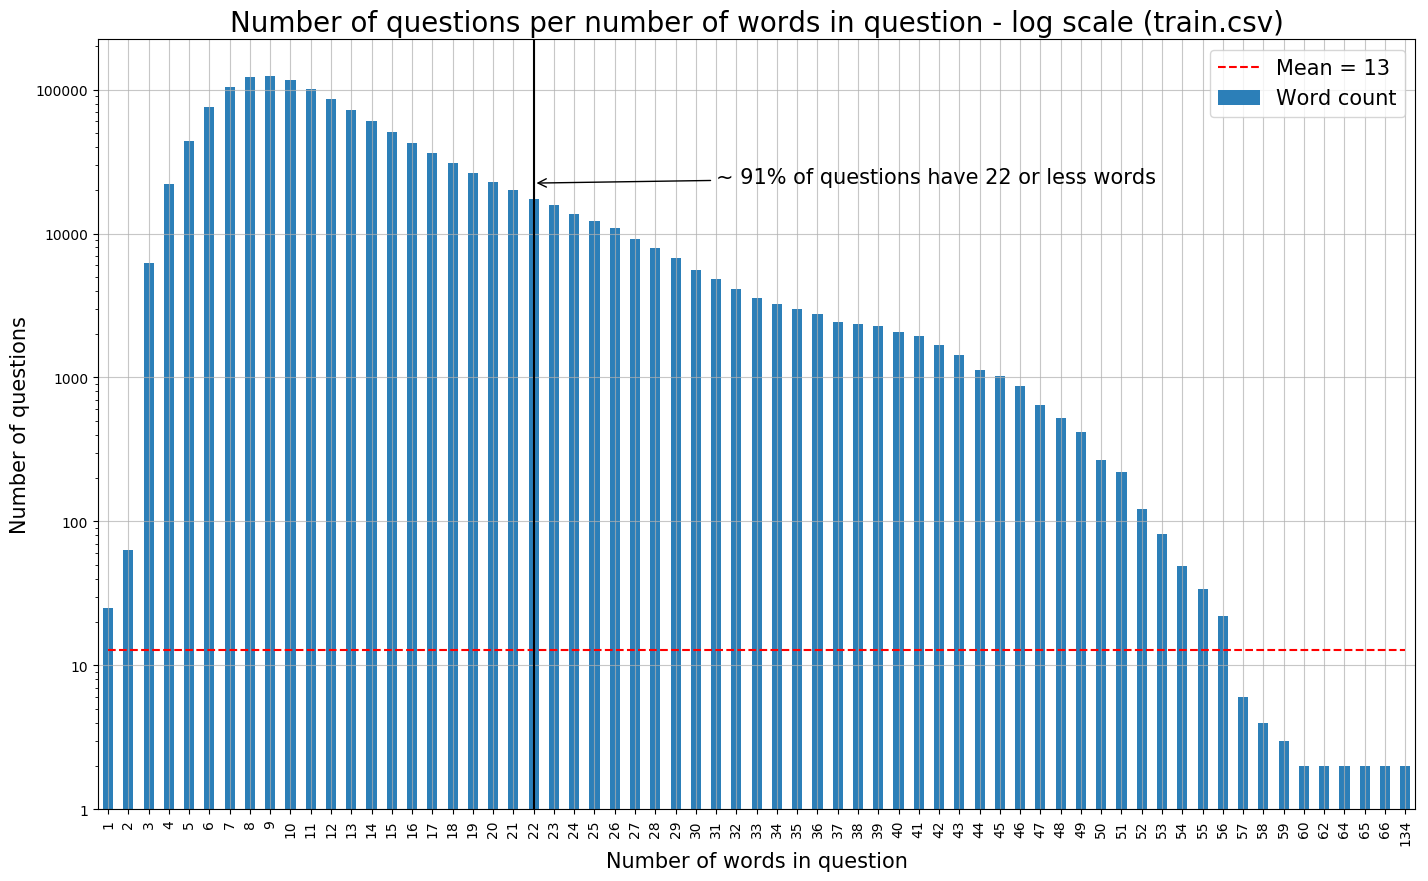

In [22]:
# Plot distribution of number of words (how many questions have x words)
fig, ax = plt.subplots(figsize=(17,10))

# Bar chart (will automatically remove zero/null values from x axis)
word_count_df.raw_word_count.plot(kind='bar', color='#2c7fb8', log=True, label='Word count')

# Format axis ticks for better readability
y_labels = ax.get_yticks()
x_labels = ax.get_xticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# add mean line to plot
y_mean = [np.mean(df.raw_word_count)]*len(x_labels)
mean_line = ax.plot(x_labels,y_mean, label='Mean = {:.0f}'.format(y_mean[0]), linestyle='--', color = 'r')

# Add line at 90% cutoff and annotate it
plt.axvline(x=21, color='k', linestyle='-')
plt.annotate('~ {:.0f}% of questions have 22 or less words'.format(word_count_df.iloc[21,1]*100), size=15, xy=(21, word_count_df.iloc[21,0]+5000), 
            xytext=(30, word_count_df.iloc[21,0]+5000), arrowprops=dict(arrowstyle="->"));

# Add grids, legends ant titles.
plt.grid(alpha=0.7)
legend = ax.legend(loc='upper right', fontsize = 15)
plt.title('Number of questions per number of words in question - log scale (train.csv)', fontdict = {'fontsize': 20})
plt.xlabel('Number of words in question', fontsize=15)
plt.ylabel('Number of questions', fontsize=15);


In [24]:
# Create a dataframe for plotting text length statistics (number of characters)
df_charcount = pd.DataFrame(df.raw_question_text_length.value_counts().sort_index())
df_charcount['cummulative'] = df_charcount.raw_question_text_length.agg('cumsum') / df.shape[0]
df_charcount[df_charcount.cummulative >= 0.9]

,raw_question_text_length,cummulative
122,3211,0.9009326847
123,3020,0.9032448730
124,2919,0.9054797331
125,2960,0.9077459839
126,2922,0.9099831409
127,2829,0.9121490948
128,2704,0.9142193455
129,2666,0.9162605025
130,2565,0.9182243313
131,2609,0.9202218476


In [25]:
# For plotting, check how much is accumulated at the last hist bin if we set the cutoff for x axis at 200
df_charcount.iloc[0:200,0].sum() / df.shape[0]

0.9854378074942464

In [26]:
# Create a dataframe for word count statistics on test data
test_word_count_df = pd.DataFrame(df_test.raw_word_count.value_counts().sort_index())
test_word_count_df['cummulative'] = test_word_count_df.raw_word_count.agg('cumsum') / df_test.shape[0]
test_word_count_df.head(50)

,raw_word_count,cummulative
2,1,0.0000177399
3,256,0.0045591627
4,950,0.0214120986
5,1923,0.0555259890
6,3259,0.1133404293
7,4607,0.1950682987
8,5255,0.2882916445
9,5324,0.3827390456
10,5081,0.4728756431
11,4216,0.5476671989


In [27]:
# For plotting, check how much is accumulated at the last hist bin if we set the cutoff for x axis at 50 for word counts
word_count_df.iloc[0:50,0].sum() / df.shape[0]

0.999587327983144

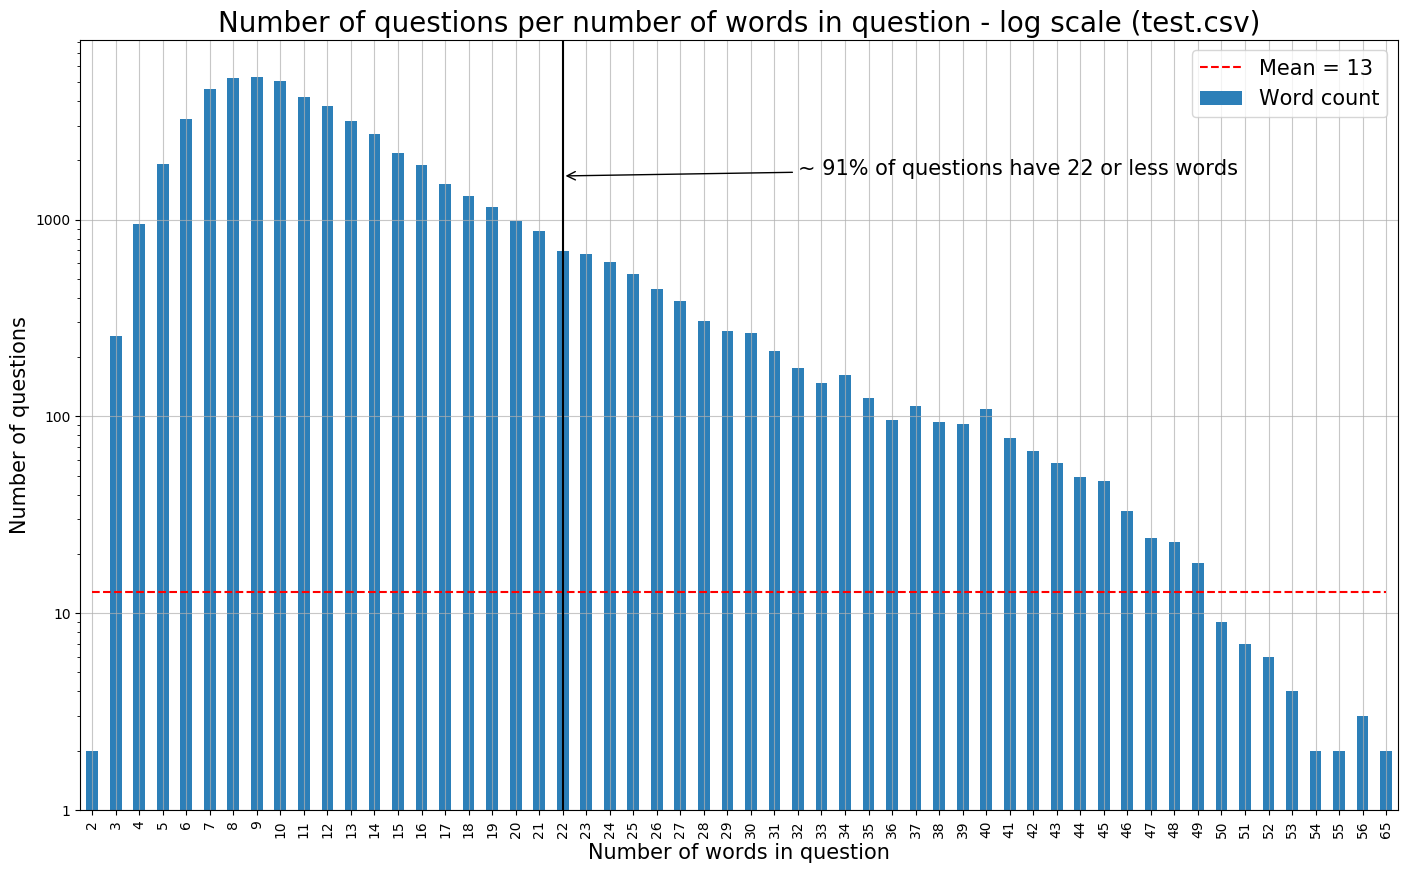

In [28]:
# Plot distribution of number of words (how many questions have x words)
fig, ax = plt.subplots(figsize=(17,10))

# Bar chart (will automatically remove zero/null values from x axis)
test_word_count_df.raw_word_count.plot(kind='bar', color='#2c7fb8', log=True, label='Word count')

# Format axis ticks for better readability
y_labels = ax.get_yticks()
x_labels = ax.get_xticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Add mean line to plot
y_mean = [np.mean(df_test.raw_word_count)]*len(x_labels)
mean_line = ax.plot(x_labels,y_mean, label='Mean = {:.0f}'.format(y_mean[0]), linestyle='--', color = 'r')

# Add line at 90% cutoff and annotate it
plt.axvline(x=20, color='k', linestyle='-')
plt.annotate('~ {:.0f}% of questions have 22 or less words'.format(test_word_count_df.iloc[20,1]*100), size=15, xy=(20, test_word_count_df.iloc[21,0]+1000), 
            xytext=(30, test_word_count_df.iloc[20,0]+1000), arrowprops=dict(arrowstyle="->"));

# Add grids, legend and labels.
plt.grid(alpha=0.7)
legend = ax.legend(loc='upper right', fontsize = 15)
plt.title('Number of questions per number of words in question - log scale (test.csv)', fontdict = {'fontsize': 20})
plt.xlabel('Number of words in question', fontsize=15)
plt.ylabel('Number of questions', fontsize=15);

Mean sincere: 12.51
Mean insincere: 17.28
Stdev sincere: 6.75
Stdev insincere: 9.57


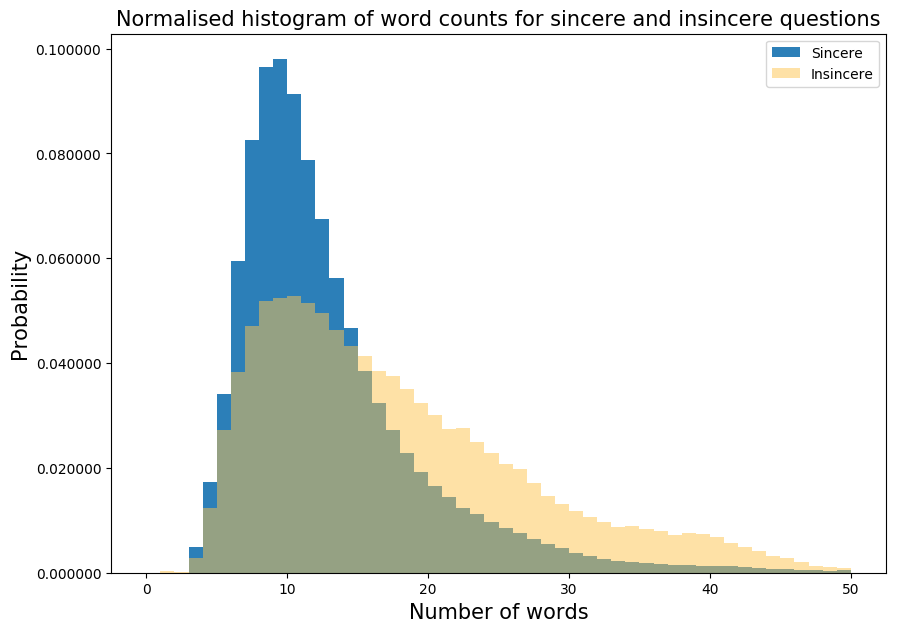

In [29]:
# PLot word count statistics for sincere and insincere questions

# Dataframes for easy plotting
sincere_df = df[df.target == 0]['raw_word_count']
insincere_df = df[df.target == 1]['raw_word_count']

#Plot histograms of 50 bins, cutoff at 50
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.hist(sincere_df, bins=50, range=[0, 50], color='#2c7fb8', density=True, label='Sincere')
a, b, c = plt.hist(insincere_df, bins=50, range=[0, 50], color='#fec44f',  density=True, alpha=0.5, label='Insincere')

# Format y ticks
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))

# Set title and labels
plt.title('Normalised histogram of word counts for sincere and insincere questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

# Print statistics
print('Mean sincere: {:.2f}\nMean insincere: {:.2f}'.format(sincere_df.mean(), 
                          insincere_df.mean()))

print('Stdev sincere: {:.2f}\nStdev insincere: {:.2f}'.format(sincere_df.std(), 
                          insincere_df.std()))

In [31]:
# Check percentage of questions added to last bin
(1 - sincere_df.value_counts().sort_index()[0:50].sum() / sincere_df.value_counts().sort_index().sum()) * 100

0.023504217701286745

Mean sincere: 68.87
Mean insincere: 98.06


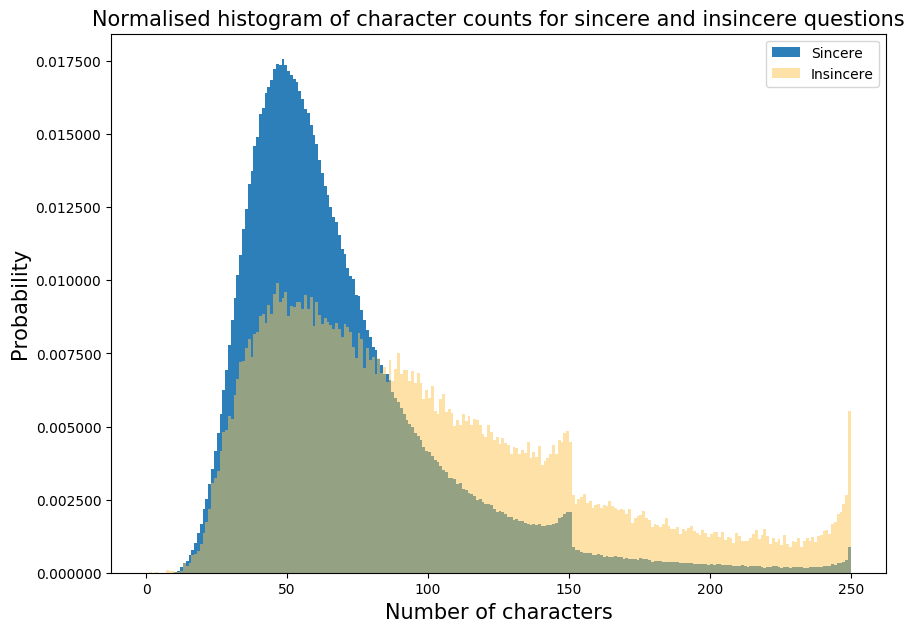

In [36]:
# Plot text length statistics

# Create dataframes and series for easy plotting
sincere_df = df[df.target == 0]['question_text']
insincere_df = df[df.target == 1]['question_text']
distribution_sincere = sincere_df.apply(len)
distribution_insincere = insincere_df.apply(len)

# Plot histograms of 250 bins, cutoff x at 250
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.hist(distribution_sincere, bins=250, range=[0, 250], color='#2c7fb8', density=True, label='Sincere')
plt.hist(distribution_insincere, bins=250, range=[0, 250], color='#fec44f', density=True, alpha=0.5, label='Insincere')

# Format ticks
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))

# Set titles and labels
plt.title('Normalised histogram of character counts for sincere and insincere questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

# Print statistics
print('Mean sincere: {:.2f}\nMean insincere: {:.2f}'.format(distribution_sincere.mean(), 
                          distribution_insincere.mean()))

In [39]:
# Create a helper columns with sentece words as list
df['question_as_list'] = df.question_text.str.split()

In [40]:
# Get the longest word in the list-column created at previous step
df['longest_word'] = df['question_as_list'].apply(lambda x: np.array([len(y) for y in x]).max())

In [41]:
# Do the same for test
df_test['question_as_list'] = df_test.question_text.str.split()
df_test['longest_word'] = df_test['question_as_list'].apply(lambda x: np.array([len(y) for y in x]).max())

In [240]:
# Get flattended list of words to get statistics across full dataset
test_word_len_list = [len(item) for sublist in df_test.question_as_list.tolist() for item in sublist]
test_word_len_list = np.array(test_word_len_list)

In [241]:
# Print statistics
print(test_word_len_list.mean())
print(test_word_len_list.max())
print(test_word_len_list.min())
print(np.median(test_word_len_list))
print(test_word_len_list.std())

4.603580932667281
169
1
4.0
2.6580904991081984


In [233]:
# Get flattended list of words to get statistics across full dataset
word_len_list = [len(item) for sublist in df.question_as_list.tolist() for item in sublist]
word_len_list = np.array(word_len_list)

In [237]:
# Print statistics
print(word_len_list.mean())
print(word_len_list.max())
print(word_len_list.min())
print(np.median(word_len_list))
print(word_len_list.std())

4.598323179300268
230
1
4.0
2.6422309697754547


Mean sincere: 68.87
Mean insincere: 98.06


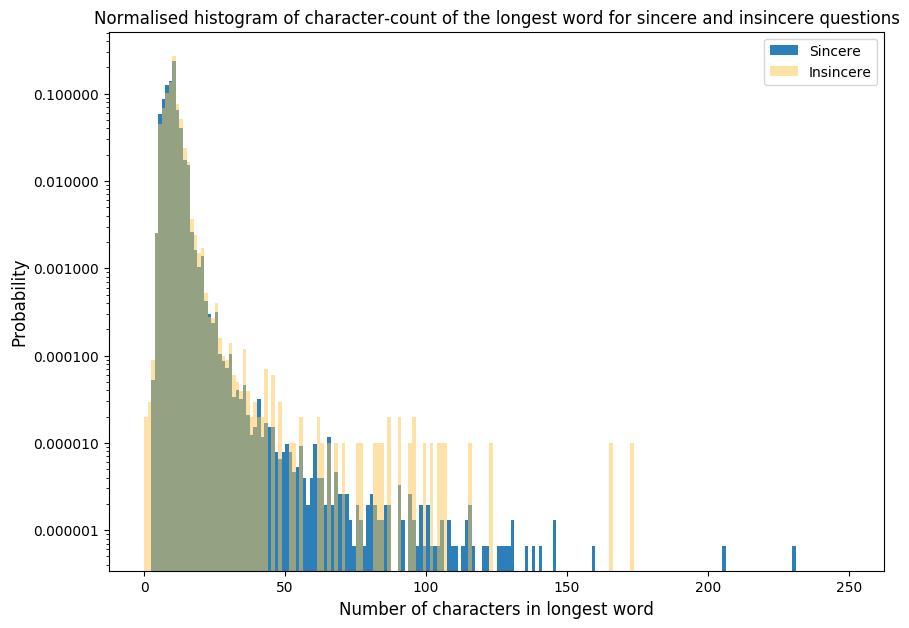

In [43]:
# Plot distribution of longest word (to compare target classes)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Histograms per target class, cutoff at 250
plt.hist(df[df.target == 0]['longest_word'], bins=200, range=[0, 250], 
         color='#2c7fb8', density=True, log=True, label='Sincere')
plt.hist(df[df.target == 1]['longest_word'], bins=200, range=[0, 250], 
         color='#fec44f', density=True, log=True, alpha=0.5, label='Insincere')

# Format axis, set legends, titles, labels
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))
plt.title('Normalised histogram of character-count of the longest word for sincere and insincere questions', fontsize=12)
plt.legend()
plt.xlabel('Number of characters in longest word', fontsize=12)
plt.ylabel('Probability', fontsize=12)


In [44]:
# Set variables for spacy tokenizer
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
parser = English()

In [45]:
def spacy_tokenizer(sentence):
    """
    Lemmatize, lowercase, remove stop words and punctuation
    """
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
#     mytokens = [word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [46]:
# Add a cleansed text column
df['clean_question_text'] = df.question_text.apply(spacy_tokenizer)

In [47]:
# Create functions to extract words, bigrams and trigrams
def word_generator(text):
    word = list(text.split())
    return word
def bigram_generator(text):
    bgram = list(nltk.bigrams(text.split()))
    bgram = [' '.join((a, b)) for (a, b) in bgram]
    return bgram
def trigram_generator(text):
    tgram = list(nltk.trigrams(text.split()))
    tgram = [' '.join((a, b, c)) for (a, b, c) in tgram]
    return tgram

In [48]:
# Get series for insincere words, bigrams and trigrams
sincere_bigrams = df[df.target == 0].clean_question_text.apply(bigram_generator)
insincere_bigrams = df[df.target == 1].clean_question_text.apply(bigram_generator)
sincere_trigrams = df[df.target == 0].clean_question_text.apply(trigram_generator)
insincere_trigrams = df[df.target == 1].clean_question_text.apply(trigram_generator)

sincere_words  = df[df.target == 0].clean_question_text.apply(word_generator)
insincere_words  = df[df.target == 1].clean_question_text.apply(word_generator)

In [49]:
# Flatten all series to lists, to produce statistics for complete dataset
sincere_words_list = sincere_words.tolist()
sincere_flat_words_list = [item for sublist in sincere_words_list for item in sublist]

insincere_words_list = insincere_words.tolist()
insincere_flat_words_list = [item for sublist in insincere_words_list for item in sublist]

insincere_trigrams_list = insincere_trigrams.tolist()
insincere_flat_trigrams_list = [item for sublist in insincere_trigrams_list for item in sublist]

insincere_bigrams_list = insincere_bigrams.tolist()
insincere_flat_bigrams_list = [item for sublist in insincere_bigrams for item in sublist]

sincere_trigrams_list = sincere_trigrams.tolist()
sincere_flat_trigrams_list = [item for sublist in sincere_trigrams_list for item in sublist]

sincere_bigrams_list = sincere_bigrams.tolist()
sincere_flat_bigrams_list = [item for sublist in sincere_bigrams for item in sublist]

In [50]:
# Use Counter object to count words, bigrams and trigrams for both target classes
insincere_words_count = Counter(insincere_flat_words_list)
sincere_words_count = Counter(sincere_flat_words_list)

insincere_trigrams_count = Counter(insincere_flat_trigrams_list)
insincere_bigrams_count = Counter(insincere_flat_bigrams_list)

sincere_trigrams_count = Counter(sincere_flat_trigrams_list)
sincere_bigrams_count = Counter(sincere_flat_bigrams_list)

In [51]:
#Print top insincere words
insincere_words_count.most_common(20)

[('people', 13044),
 ('woman', 7098),
 ('trump', 6606),
 ('like', 6149),
 ('indian', 5671),
 ('muslim', 5579),
 ('man', 5496),
 ('american', 4915),
 ('think', 4457),
 ('white', 4250),
 ('doe', 4105),
 ('black', 3519),
 ('girl', 3420),
 ('quora', 3417),
 ('country', 3365),
 ('india', 3320),
 ('want', 3021),
 ('liberal', 2637),
 ('sex', 2628),
 ('hate', 2586)]

In [36]:
#Print top insincere trigrams
insincere_trigrams_count.most_common(20)

[('kim jong un', 134),
 ('ask stupid question', 76),
 ('12 year old', 68),
 ('year old girl', 67),
 ('united states america', 60),
 ('doe donald trump', 57),
 ('president united states', 53),
 ('14 year old', 49),
 ('black lives matter', 46),
 ('year old boy', 45),
 ('13 year old', 43),
 ('think donald trump', 40),
 ('president donald trump', 38),
 ('hate black people', 37),
 ('doe quora allow', 37),
 ('15 year old', 36),
 ('gun control advocate', 36),
 ('year old son', 34),
 ('barack hussein obama', 34),
 ('hate white people', 33)]

In [37]:
# Print top insincere bigrams
insincere_bigrams_count.most_common(20)

[('donald trump', 1416),
 ('white people', 902),
 ('black people', 823),
 ('year old', 606),
 ('united states', 563),
 ('president trump', 482),
 ('trump supporter', 464),
 ('hillary clinton', 400),
 ('people think', 366),
 ('north indian', 365),
 ('african american', 336),
 ('black man', 312),
 ('chinese people', 310),
 ('white man', 308),
 ('indian girl', 307),
 ('south indian', 298),
 ('indian muslim', 295),
 ('look like', 290),
 ('north korea', 260),
 ('white woman', 256)]

In [38]:
# Print top sincere trigrams
sincere_trigrams_count.most_common(20)

[('useful tip start', 714),
 ('tip start work', 714),
 ('good hotel short', 519),
 ('hotel short term', 519),
 ('short term business', 519),
 ('term business traveler', 519),
 ('good bad neighborhood', 515),
 ('doe feel like', 496),
 ('14 year old', 394),
 ('15 year old', 366),
 ('year old girl', 359),
 ('consideration write biography', 358),
 ('16 year old', 355),
 ('lesser know fact', 325),
 ('13 year old', 319),
 ('literary device use', 314),
 ('17 year old', 308),
 ('high school student', 307),
 ('new york city', 293),
 ('doe mean dream', 292)]

In [39]:
# Print top sincere bigrams
sincere_bigrams_count.most_common(20)

[('year old', 5442),
 ('doe mean', 4815),
 ('look like', 3067),
 ('united states', 3046),
 ('feel like', 3025),
 ('high school', 2864),
 ('computer science', 2679),
 ('donald trump', 2052),
 ('social medium', 2007),
 ('long doe', 1854),
 ('mechanical engineer', 1654),
 ('north korea', 1591),
 ('jee mains', 1508),
 ('major accomplishment', 1466),
 ('doe feel', 1376),
 ('people think', 1342),
 ('software engineer', 1288),
 ('2 year', 1286),
 ('question ask', 1244),
 ('pro con', 1239)]

In [53]:
# Create dataframes for plotting
plt_trigrams_insincere =  pd.DataFrame(insincere_trigrams_count.most_common(20), columns=['trigram', 'frequency'])
plt_trigrams_sincere =  pd.DataFrame(sincere_trigrams_count.most_common(20), columns=['trigram', 'frequency'])

plt_bigrams_insincere =  pd.DataFrame(insincere_bigrams_count.most_common(20), columns=['bigram', 'frequency'])
plt_bigrams_sincere =  pd.DataFrame(sincere_bigrams_count.most_common(20), columns=['bigram', 'frequency'])

plt_words_insincere =  pd.DataFrame(insincere_words_count.most_common(20), columns=['word', 'frequency'])
plt_words_sincere =  pd.DataFrame(sincere_words_count.most_common(20), columns=['word', 'frequency'])

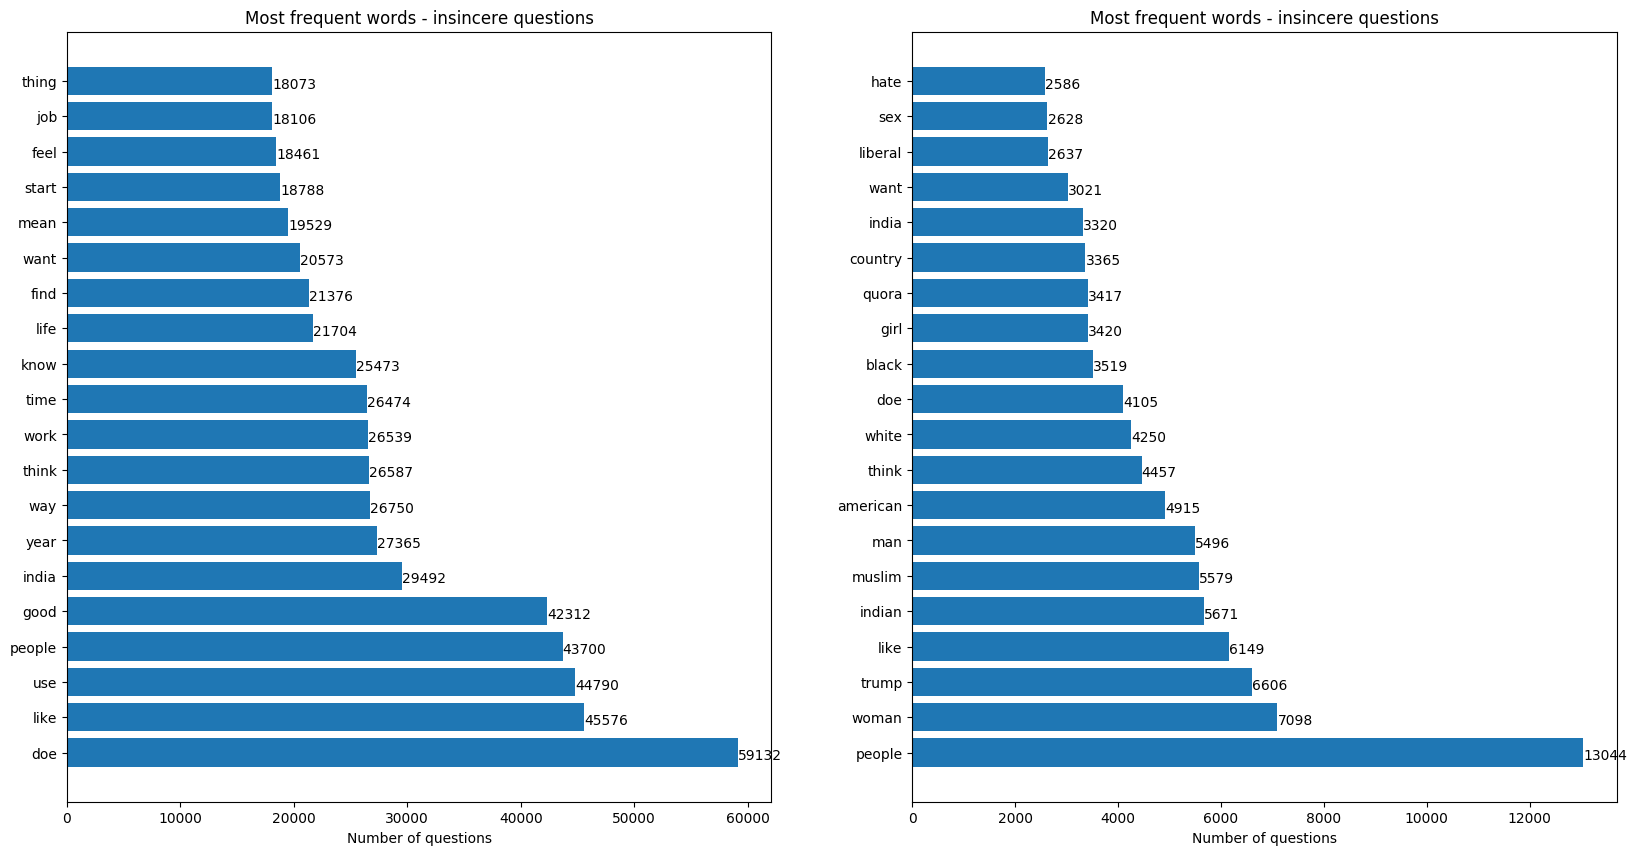

In [84]:
# Create plot to compare insincere and sincere words
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Add side by side plots
ax[0].barh(plt_words_sincere.word, plt_words_sincere.frequency)
ax[1].barh(plt_words_insincere.word, plt_words_insincere.frequency)


# Add numbers to bars
for i in reversed(range(plt_words_sincere.shape[0])):
    val = plt_words_sincere.iloc[i,1]
    ax[0].text(x=val+1, y = i-0.2, s=val)
ax[0].set_title('Most frequent words - insincere questions')

# Set axis
plt.sca(ax[0])
# plt.yticks(rotation=50)
plt.xlabel('Number of questions');

# Set axis
plt.sca(ax[1])

# Add numbers to bars
for i in reversed(range(plt_words_insincere.shape[0])):
    val = plt_words_insincere.iloc[i,1]
    ax[1].text(x=val+1, y = i-0.2, s=val)
ax[1].set_title('Most frequent words - insincere questions')

# Set axis
plt.sca(ax[1])
# plt.yticks(rotation=50)
plt.xlabel('Number of questions');

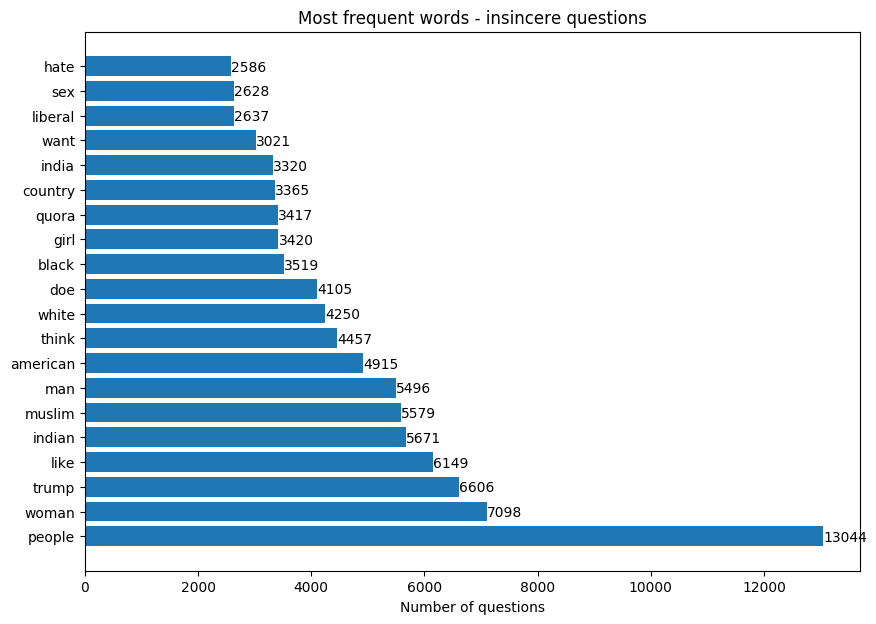

In [55]:
# Just a big versions of wordplot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.barh(plt_words_insincere.word, plt_words_insincere.frequency)

for i in reversed(range(plt_words_insincere.shape[0])):
    val = plt_words_insincere.iloc[i,1]
    plt.text(x=val+1, y = i-0.2, s=val)
plt.title('Most frequent words - insincere questions')
plt.xlabel('Number of questions');

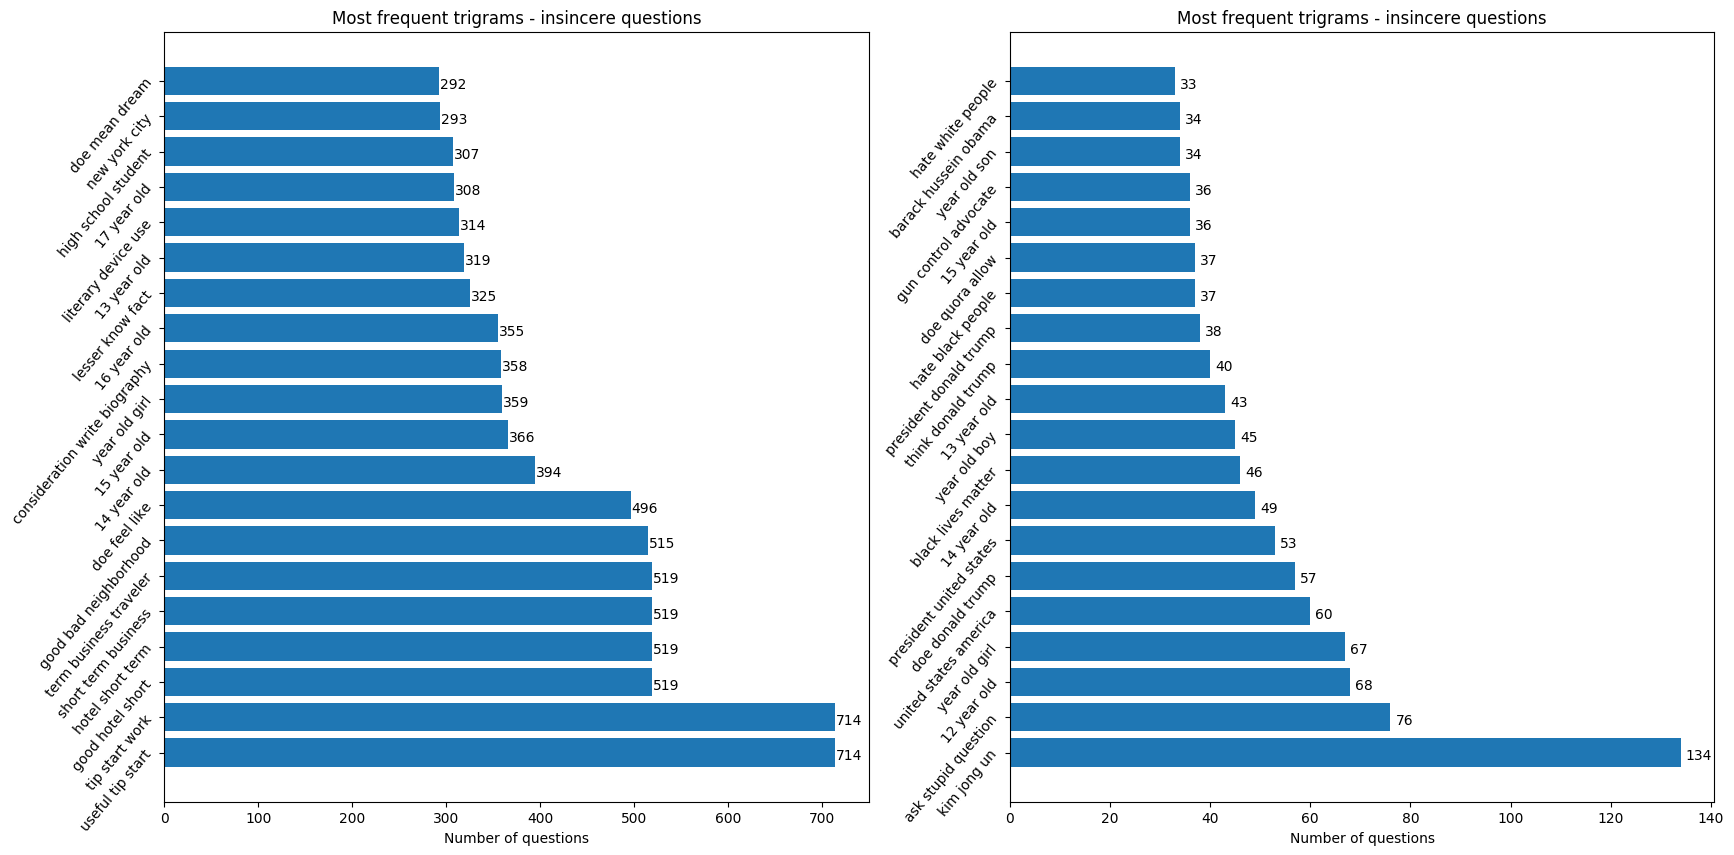

In [80]:
# Compare trigrams as well
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Side by side plots
ax[0].barh(plt_trigrams_sincere.trigram, plt_trigrams_sincere.frequency)
ax[1].barh(plt_trigrams_insincere.trigram, plt_trigrams_insincere.frequency)


# Add numbers to bars
for i in reversed(range(plt_trigrams_sincere.shape[0])):
    val = plt_trigrams_sincere.iloc[i,1]
    ax[0].text(x=val+1, y = i-0.2, s=val)
    
# Titles and labels
ax[0].set_title('Most frequent trigrams - insincere questions')
plt.sca(ax[0])
plt.yticks(rotation=50)
plt.xlabel('Number of questions');

# Set axis
plt.sca(ax[1])

# Add numbers to bars
for i in reversed(range(plt_trigrams_insincere.shape[0])):
    val = plt_trigrams_insincere.iloc[i,1]
    ax[1].text(x=val+1, y = i-0.2, s=val)
    
# Add labels titles
ax[1].set_title('Most frequent trigrams - insincere questions')
plt.sca(ax[1])
plt.yticks(rotation=50)
plt.xlabel('Number of questions');

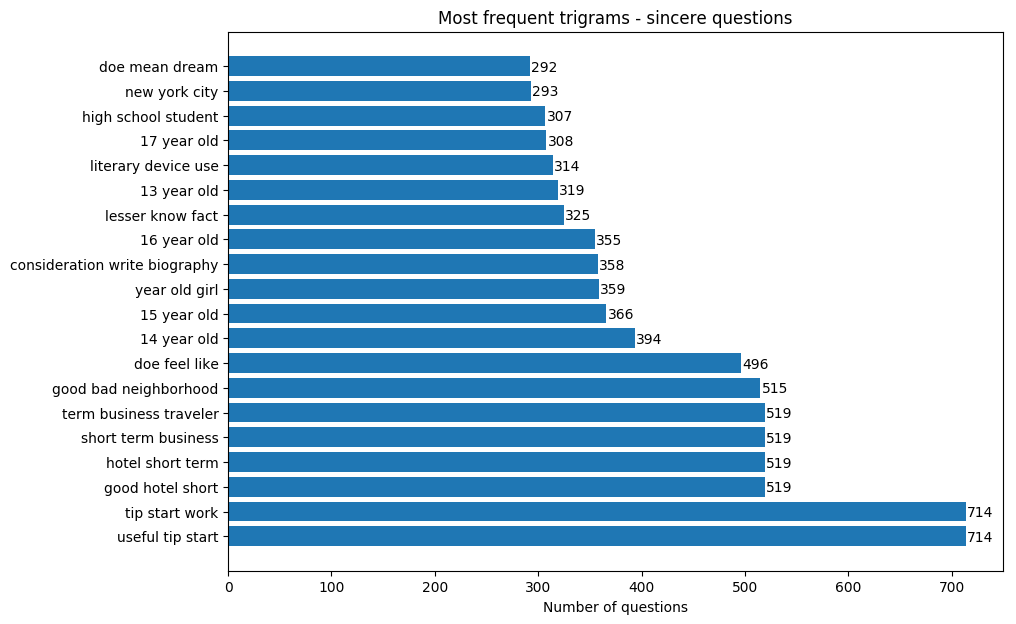

In [48]:

# Bigger trigrams plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.barh(plt_trigrams_sincere.trigram, plt_trigrams_sincere.frequency)

for i in reversed(range(plt_trigrams_sincere.shape[0])):
    val = plt_trigrams_sincere.iloc[i,1]
    plt.text(x=val+1, y = i-0.2, s=val)
plt.title('Most frequent trigrams - sincere questions')
plt.xlabel('Number of questions');

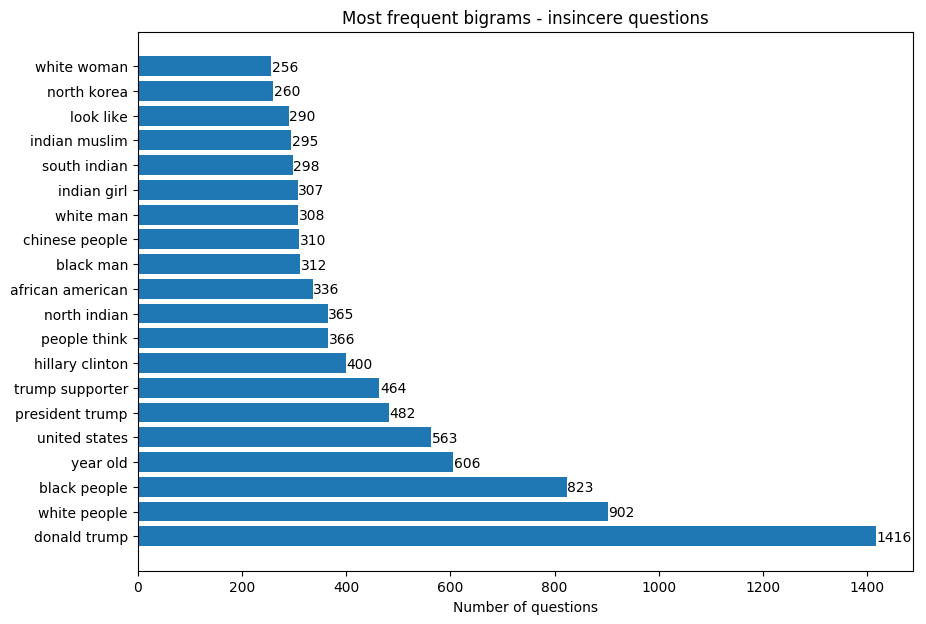

In [49]:
# Insincere bigrams plot

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.barh(plt_bigrams_insincere.bigram, plt_bigrams_insincere.frequency)

for i in reversed(range(plt_bigrams_insincere.shape[0])):
    val = plt_bigrams_insincere.iloc[i,1]
    plt.text(x=val+1, y = i-0.2, s=val)
plt.title('Most frequent bigrams - insincere questions')
plt.xlabel('Number of questions');

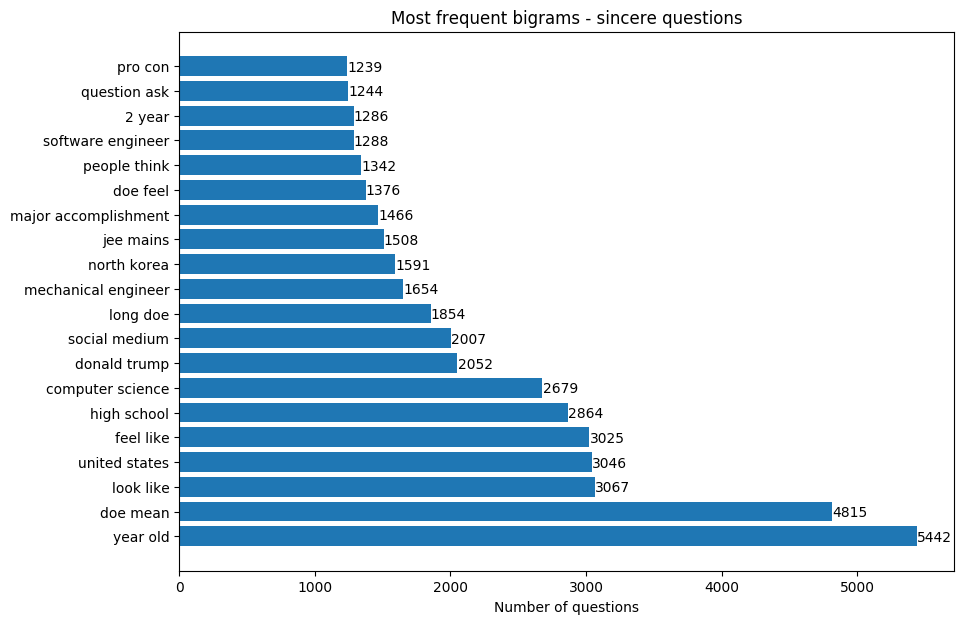

In [50]:
# Bigrams sincere

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.barh(plt_bigrams_sincere.bigram, plt_bigrams_sincere.frequency)

for i in reversed(range(plt_bigrams_sincere.shape[0])):
    val = plt_bigrams_sincere.iloc[i,1]
    plt.text(x=val+1, y = i-0.2, s=val)
plt.title('Most frequent bigrams - sincere questions')
plt.xlabel('Number of questions');

In [13]:
# Find a way to incorporate length of text! Of short words, many are insincere
df[df.question_text.str.len() <= 10].target.value_counts()

1    24
0    13
Name: target, dtype: int64

In [10]:
# Check a single short qustion
df[df.qid == '4e27c853e0b475b23d2c']

,qid,question_text,target
398964,4e27c853e0b475b23d2c,Politics:,1
